In [1]:
import tensorflow as tf
# List all physical GPU devices
physical_devices = tf.config.list_physical_devices('GPU')

if physical_devices:
    try:
        # Enable memory growth for the first GPU
        tf.config.experimental.set_memory_growth(physical_devices[0], True)
        print("Memory growth enabled for:", physical_devices[0])
    except RuntimeError as e:
        # Memory growth must be set before initializing GPUs
        print("Error setting memory growth:", e)
else:
    print("No GPU devices found.")

with tf.device('/cpu:0'):
    import seaborn as sns
    from sklearn.metrics import confusion_matrix
    from sklearn.svm import SVC
    from tensorflow.python.client import device_lib
    import cv2
    import os
    import numpy as np
    import matplotlib.pyplot as plt
    from sklearn.model_selection import train_test_split, GridSearchCV
    from sklearn.metrics import classification_report, accuracy_score
    from tensorflow.keras import layers, models
    from sklearn.preprocessing import LabelEncoder,StandardScaler
    from tensorflow.keras.utils import to_categorical
    from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler, ModelCheckpoint
    import h5py
    import gc
    import winsound


    gc.enable

    from tensorflow.python.client import device_lib
    print(device_lib.list_local_devices())

Memory growth enabled for: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 18160606171980551334
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 4158652416
locality {
  bus_id: 1
  links {
  }
}
incarnation: 1140305187707049966
physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1660 Ti, pci bus id: 0000:01:00.0, compute capability: 7.5"
xla_global_id: 416903419
]


In [2]:
#import tensorflow as tf
#
## Set mixed precision policy
#from tensorflow.keras.mixed_precision import set_global_policy
#
#set_global_policy('mixed_float16')
#
## Check if the policy is set
#print("Mixed precision policy:", tf.keras.mixed_precision.global_policy())

In [3]:
with tf.device('/cpu:0'):
    # Load the numpy array X from the compressed .npz file
    #X_train = np.load(r'C:\Users\princ\Downloads\Vision datasets\workspace\X_augemented_train.npz')
    X_train = np.load(r'C:\Users\princ\Downloads\Vision datasets\workspace\X_train_5.npz')
    X_test  = np.load(r'C:\Users\princ\Downloads\Vision datasets\workspace\X_test_5.npz')
    #X_val   = np.load(r'C:\Users\princ\Downloads\Vision datasets\workspace\X_val.npz')
    #Y_train = np.load(r'C:\Users\princ\Downloads\Vision datasets\workspace\Y_augemented_train.npz')
    Y_train = np.load(r'C:\Users\princ\Downloads\Vision datasets\workspace\Y_train_5.npz')
    Y_test  = np.load(r'C:\Users\princ\Downloads\Vision datasets\workspace\Y_test_5.npz')
    #Y_val   = np.load(r'C:\Users\princ\Downloads\Vision datasets\workspace\Y_val.npz')
    
    
    X_train =X_train['X']
    X_test  =X_test ['X']
    #X_val   =X_val  ['X']
    Y_train =Y_train['X']
    Y_test  =Y_test ['X']
    #Y_val = Y_val ['X']

    # One-hot encode the labels
    label_encoder = LabelEncoder()
    y_train_encoded = to_categorical(label_encoder.fit_transform(Y_train))
    y_test_encoded = to_categorical(label_encoder.transform(Y_test))
    #y_val_encoded = to_categorical(label_encoder.transform(Y_val))

    X_train = tf.convert_to_tensor(X_train, np.float32)
    X_test = tf.convert_to_tensor(X_test, np.float32)
    #X_val = tf.convert_to_tensor(X_val, np.float32)

    
    y_train_encoded = tf.convert_to_tensor(y_train_encoded, np.float32)
    y_test_encoded = tf.convert_to_tensor(y_test_encoded, np.float32)
    #y_val_encoded = tf.convert_to_tensor(y_val_encoded, np.float32)

    image_input_shape=(X_train[0].shape)
    num_classes=y_train_encoded.shape[1]


    print(image_input_shape, num_classes)

(64, 64, 3) 50


In [4]:
# Define the encoder
def build_encoder(input_shape):
    encoder = models.Sequential(name="enhanced_encoder")
    encoder.add(layers.InputLayer(input_shape=input_shape))
    encoder.add(layers.Conv2D(256, (3, 3), activation='linear', padding='same',kernel_initializer='he_normal', input_shape=input_shape))
    encoder.add(layers.BatchNormalization())
    encoder.add(layers.MaxPooling2D((2, 2)))
    encoder.add(layers.Conv2D(128, (3, 3), activation='linear', padding='same',kernel_initializer='he_normal'))
    encoder.add(layers.BatchNormalization())
    encoder.add(layers.MaxPooling2D((4, 4)))
    encoder.add(layers.Conv2D(64, (3, 3), activation='linear', padding='same',kernel_initializer='he_normal', name="last"))

    return encoder  


model1 = build_encoder(image_input_shape)
model1.summary()
#Get the output of the last layer
last_layer = model1.get_layer(name="last")
latent_dim_encoder = last_layer.output_shape
latent_dim_encoder = latent_dim_encoder[1:]
print(latent_dim_encoder)

Model: "enhanced_encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 256)       7168      
                                                                 
 batch_normalization (BatchN  (None, 64, 64, 256)      1024      
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 256)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 128)       295040    
                                                                 
 batch_normalization_1 (Batc  (None, 32, 32, 128)      512       
 hNormalization)                                                 
                                                  

In [5]:
# SVM def
def SVM(X_train, y_train, X_test, y_test):
    # Step 4: Train SVC with RBF kernel
    svm = SVC(kernel='rbf', C=10)  # RBF kernel with hyperparameters
    svm.fit(X_train, y_train)  # Train the model
    
    gc.collect()
    tf.keras.backend.clear_session()
    
    # Step 5: Evaluate Model
    y_pred = svm.predict(X_test)  # Make predictions

    
    print("Accuracy:", accuracy_score(y_test, y_pred))

    return y_pred

In [6]:
def train_svm_with_encoder(X_train, y_train, X_test, y_test, input_shape):
    # Build and train encoder
    encoder = build_encoder(input_shape)
    encoder.load_weights(r'C:\Users\princ\Downloads\Vision datasets\temp\cnn_encoder_weights.h5', by_name=True)
    
    # Extract features using the encoder
    X_train_features = encoder.predict(X_train)  # Extract features from X_train
    X_train_features = X_train_features.reshape(X_train.shape[0], -1)  # Flatten features

    X_test_features = encoder.predict(X_test)  # Extract features from X_test
    X_test_features = X_test_features.reshape(X_test.shape[0], -1)  # Flatten features

    # Ensure labels are 1D arrays (decode from one-hot encoding if needed)
    y_train = np.argmax(y_train, axis=1) if y_train.ndim > 1 else y_train
    y_test = np.argmax(y_test, axis=1) if y_test.ndim > 1 else y_test

    # Train and evaluate the SVM
    y_pred = SVM(X_train_features, y_train, X_test_features, y_test)


    return y_pred


In [7]:
y_pred = train_svm_with_encoder(X_train, Y_train, X_test, Y_test, image_input_shape)

24/24 [==============================] - 0s 16ms/step
Accuracy: 0.41160949868073876


In [8]:
winsound.Beep(300, 500)  # Frequency: 1000 Hz, Duration: 500 ms
winsound.Beep(300, 500)  # Frequency: 1000 Hz, Duration: 500 ms
winsound.Beep(300, 500)  # Frequency: 1000 Hz, Duration: 500 ms
winsound.Beep(800, 800)  # Frequency: 1000 Hz, Duration: 500 ms

In [10]:

def visualize_results(y_test, y_predict):
    # y_predict: Predictions from SVM (already class labels)
    # y_test: True labels (should be class labels, not one-hot encoded)

    # Compute confusion matrix
    cm = confusion_matrix(y_test, y_predict)

    # Plot confusion matrix with a wider figure
    plt.figure(figsize=(23, 23))  # Wider graph: 12 units wide, 6 units high
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.arange(len(np.unique(y_test))), yticklabels=np.arange(len(np.unique(y_test))))
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

def class_wise_accuracy(y_test, y_predict):
    # y_predict: Predictions from SVM (class labels)
    # y_test: True labels (class labels)

    # Compute confusion matrix
    cm = confusion_matrix(y_test, y_predict)

    # Calculate class-wise accuracy
    class_accuracies = cm.diagonal() / cm.sum(axis=1)  # Diagonal elements (correct predictions) / Row sums (total class instances)

    # Print class-wise accuracy
    print("Class-wise accuracy:")
    for i, accuracy in enumerate(class_accuracies):
        print(f"Class {i}: {accuracy * 100:.2f}%")

    # Plot class-wise accuracy as a bar chart with a wider figure
    plt.figure(figsize=(20, 6))  # Wider graph: 12 units wide, 6 units high
    plt.bar(range(len(class_accuracies)), class_accuracies * 100, color='skyblue')
    plt.xlabel('Class')
    plt.ylabel('Accuracy (%)')
    plt.title('Class-wise Accuracy')
    plt.xticks(range(len(class_accuracies)))
    plt.ylim(0, 100)
    plt.show()

    return class_accuracies

def show_images_from_class(X, y, class_label, num_images=5):
    """
    Display a given number of images from a specified class, arranged with 5 images per row.
    
    Parameters:
    - X: The image data (features) as a numpy array or pandas dataframe.
    - y: The labels corresponding to the images (class labels).
    - class_label: The class label for which to show the images.
    - num_images: Number of images to display (default is 5).
    """
    # Find the indices of the images that belong to the given class
    class_indices = np.where(y == class_label)[0]
    
    # Randomly select 'num_images' indices from the class
    selected_indices = np.random.choice(class_indices, num_images, replace=False)
    
    # Calculate the number of rows needed to display the images in 5 per row
    num_rows = (num_images // 5) + (num_images % 5 != 0)
    
    # Set up the plot
    plt.figure(figsize=(15, 3 * num_rows))
    
    for i, idx in enumerate(selected_indices):
        plt.subplot(num_rows, 5, i+1)  # Rows x 5 columns
        plt.imshow(X[idx], cmap='gray')  # Assuming grayscale images, adjust if RGB
        plt.title(f"Class {class_label}")
        plt.axis('off')  # Hide axes
    
    plt.show()

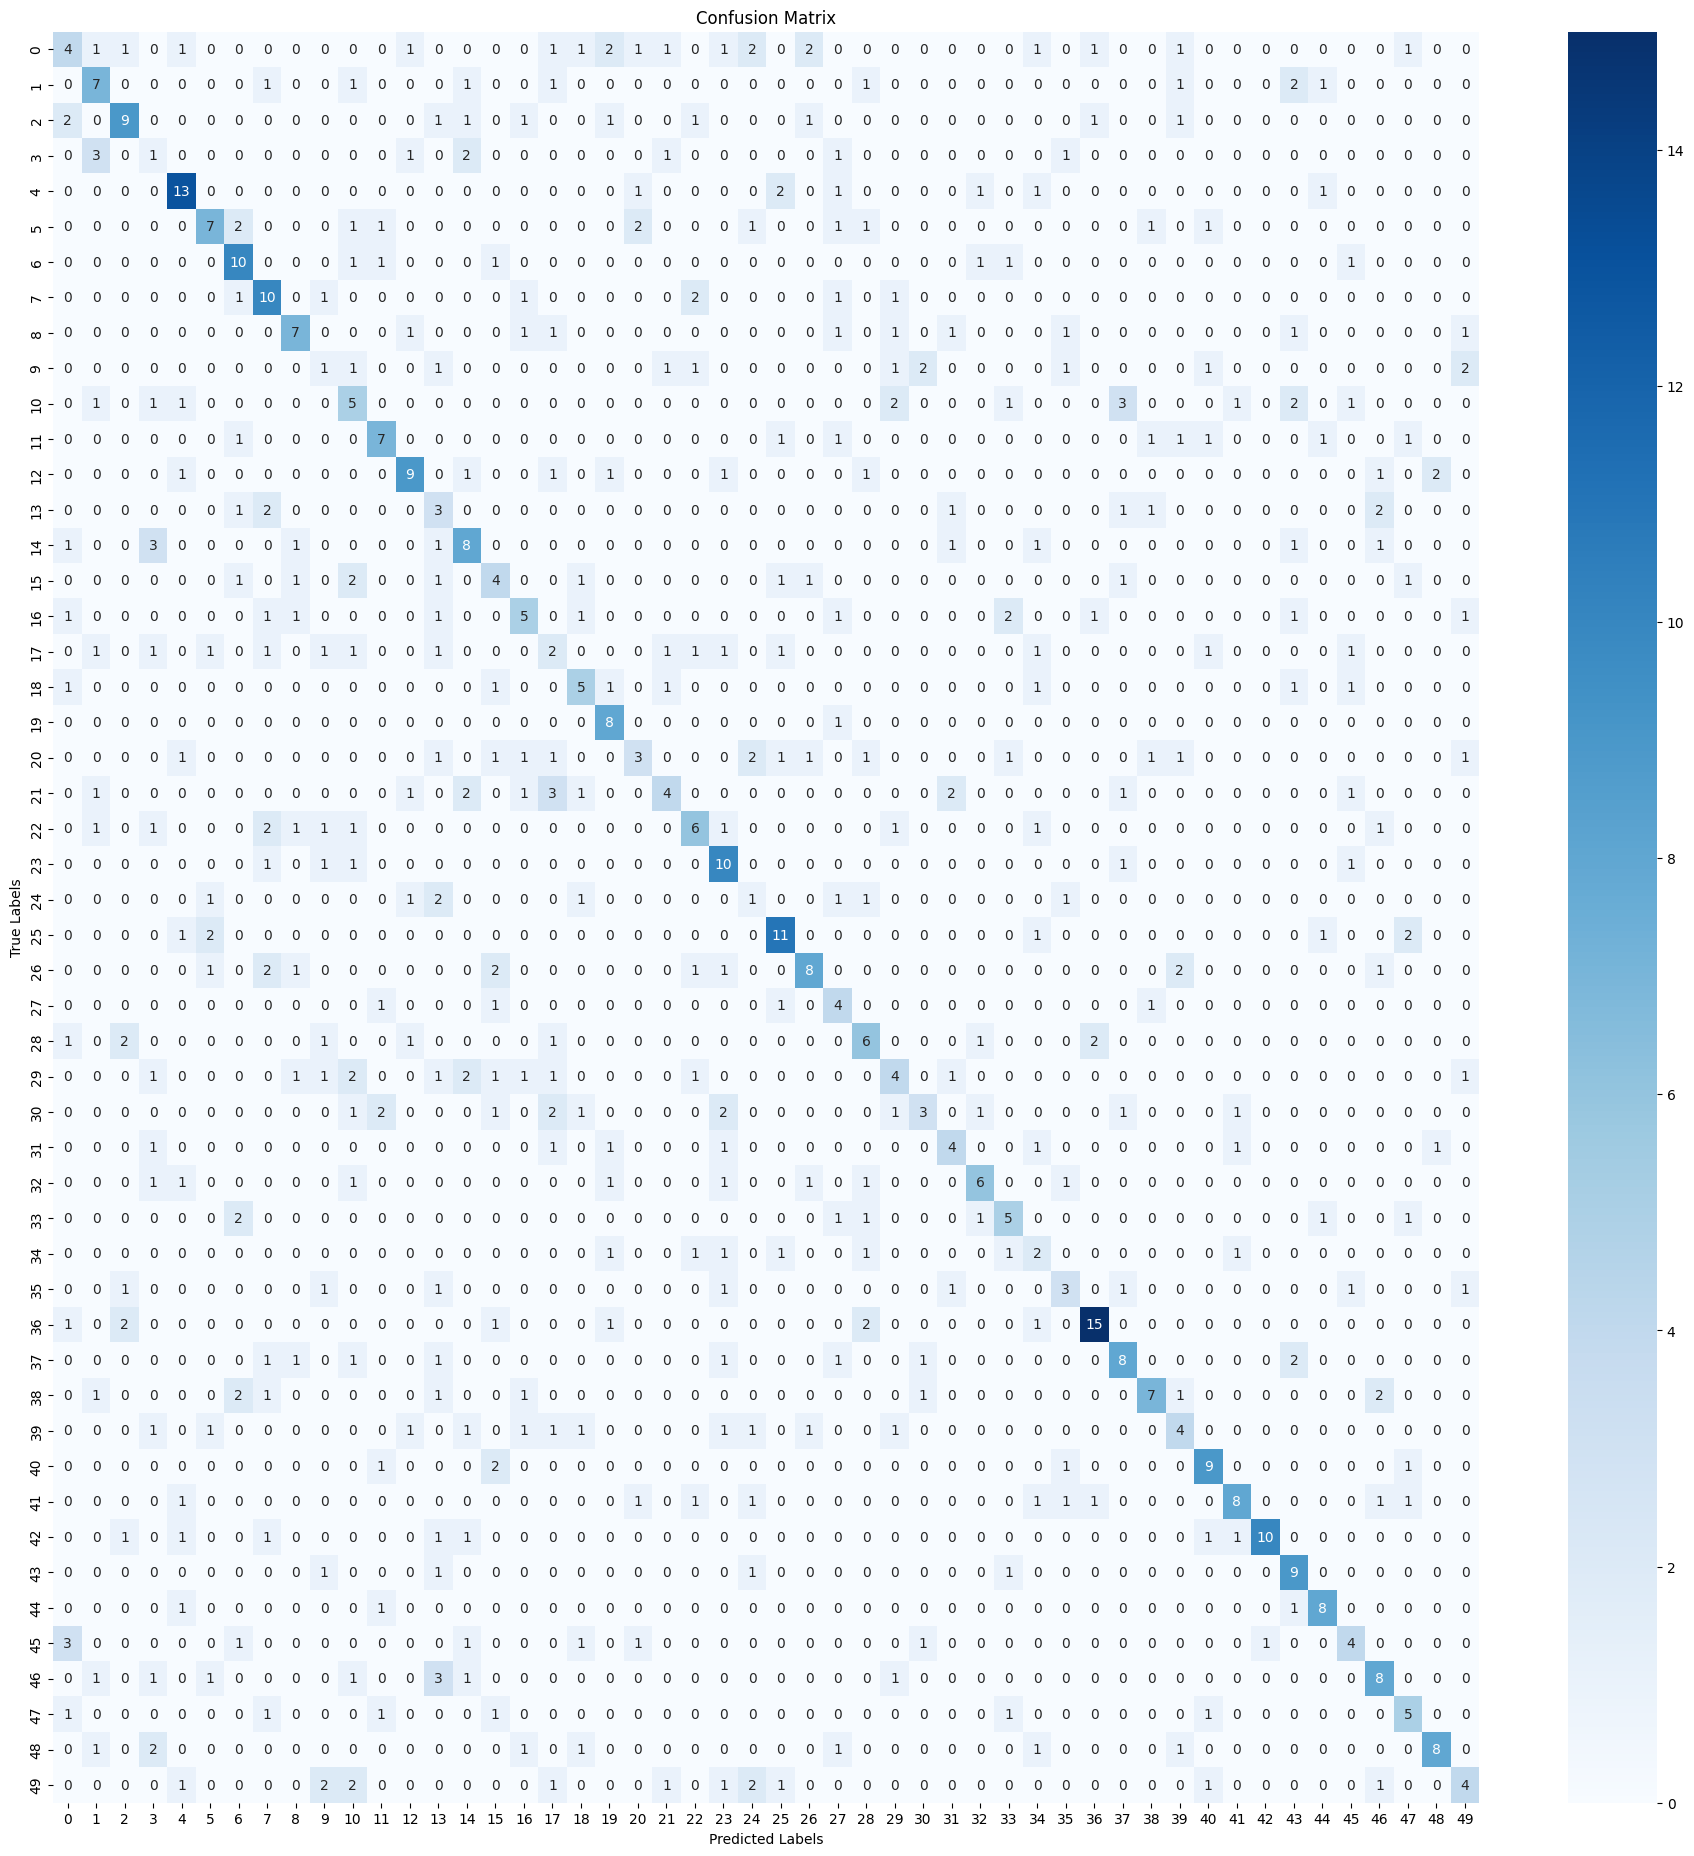

Class-wise accuracy:
Class 0: 17.39%
Class 1: 43.75%
Class 2: 47.37%
Class 3: 10.00%
Class 4: 65.00%
Class 5: 38.89%
Class 6: 62.50%
Class 7: 58.82%
Class 8: 43.75%
Class 9: 8.33%
Class 10: 27.78%
Class 11: 46.67%
Class 12: 50.00%
Class 13: 27.27%
Class 14: 44.44%
Class 15: 28.57%
Class 16: 31.25%
Class 17: 12.50%
Class 18: 41.67%
Class 19: 88.89%
Class 20: 17.65%
Class 21: 23.53%
Class 22: 35.29%
Class 23: 66.67%
Class 24: 11.11%
Class 25: 61.11%
Class 26: 42.11%
Class 27: 50.00%
Class 28: 40.00%
Class 29: 22.22%
Class 30: 18.75%
Class 31: 36.36%
Class 32: 42.86%
Class 33: 41.67%
Class 34: 22.22%
Class 35: 27.27%
Class 36: 65.22%
Class 37: 47.06%
Class 38: 41.18%
Class 39: 26.67%
Class 40: 64.29%
Class 41: 47.06%
Class 42: 58.82%
Class 43: 69.23%
Class 44: 72.73%
Class 45: 30.77%
Class 46: 47.06%
Class 47: 45.45%
Class 48: 50.00%
Class 49: 23.53%


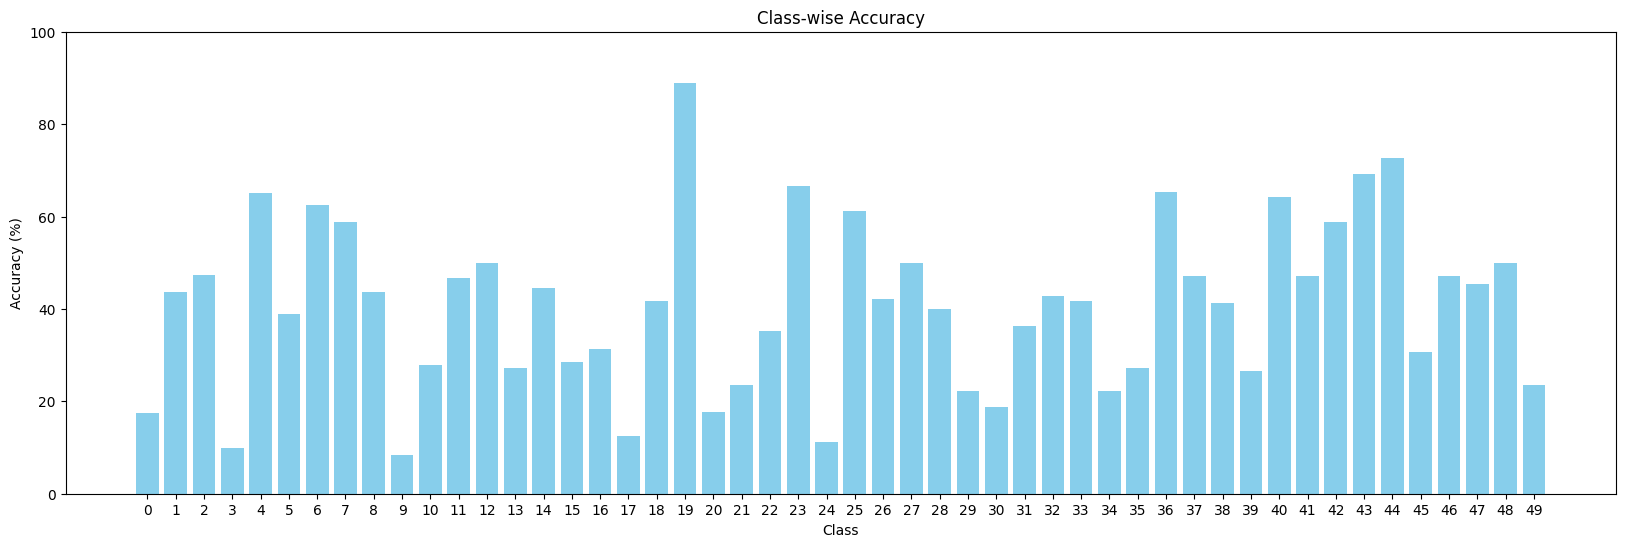

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

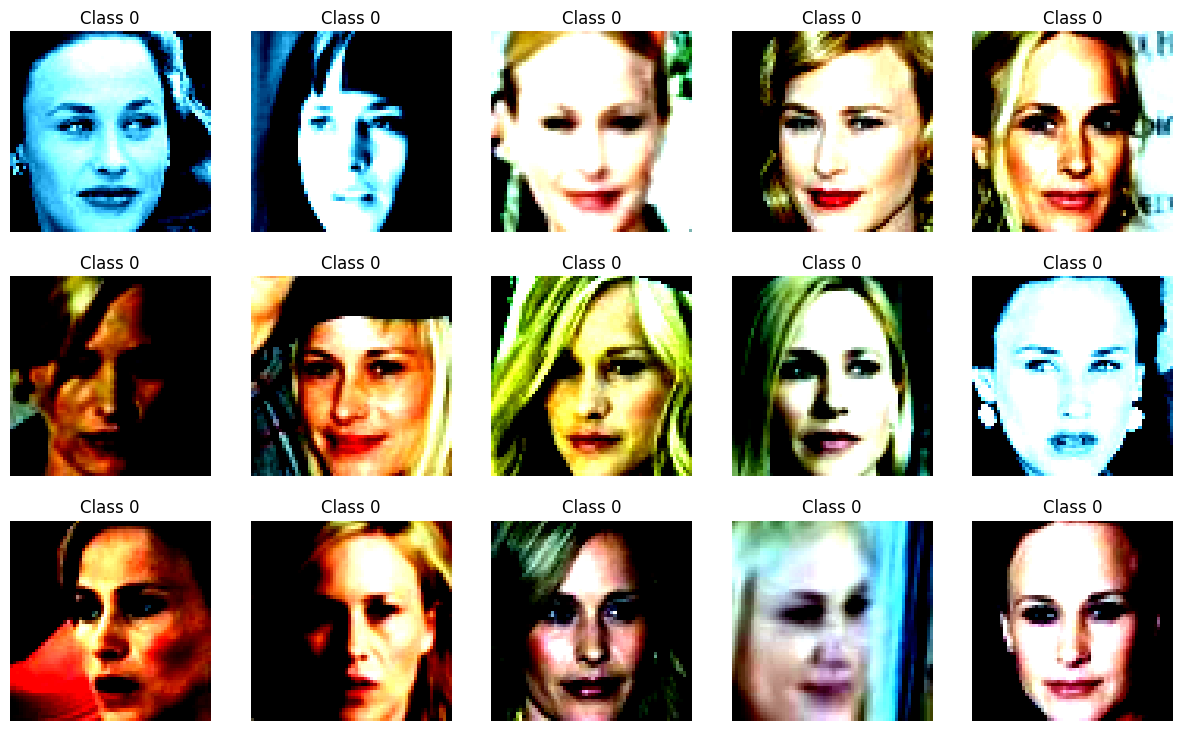

In [11]:
# Visualize confusion matrix
visualize_results(Y_test, y_pred)

# Calculate class-wise accuracy
class_wise_accuracy(Y_test, y_pred)

# Show images for a specific class (e.g., class 0)
show_images_from_class(X_test, Y_test, class_label=0, num_images=15)